# Описание проекта

Нам предоставлены данные из интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. 

Стоит задача выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными.

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
data = pd.read_csv('games.csv')
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Бросается в глаза что нужно поправить назания столбцов, типы данных и обработать пропуски

## Подготовка данных

In [4]:
data = data.rename(columns = str.lower) #название столбцов все с маленькой буквы теперь

In [5]:
#data['user_score'] = pd.to_numeric(data['user_score']) #странное значение в 119 индексе, посмотрим
data.query('index == 119') # заменим на Nan, это скорее всего ошибка ввода
data['user_score'] = pd.to_numeric(data['user_score'], errors = 'coerce')
data.info() #проверим

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [6]:
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [7]:
data = data.dropna(subset = ['name']) #игры без названия всего 2 можно удалить
data = data.dropna(subset = ['year_of_release']) #игры без даты релиза скорее всего старые и их мало, едва ли их удаление изменит статистику

In [8]:
data['year_of_release'] = data['year_of_release'].astype('int') # год смотрится правильнее как int

In [9]:
data.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

Много пропусков в баллах оценок критиков и пользователей. Так же они отличаются по шкале 100 балльная и 10ти. Я приведу 10ти балльную шкалу так же к стабалльной, а пропуски в оценках игры попробую заполнить соседней оценкой из той же строчки критика или пользователя. Я позволю себе это допущение исходя из того что чаще всего оценки критиков и пользователей не сильно различны. Статья с разбором и корреляцией оценок критиков и пользователей https://habr.com/ru/post/519264/ . 

In [10]:
data['user_score'] = data['user_score'] * 10 # пользователи теперь тоже на стобалльной шкале

In [11]:
data['critic_score'] = data['critic_score'].fillna(data['user_score']) # заменили пустые значения зна значения в соседних строках
data['user_score'] = data['user_score'].fillna(data['critic_score'])

In [13]:
data.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       7892
user_score         7892
rating             6676
dtype: int64

Замена помогла но не сильно. Оставим пока так. Рейтинг Nan на 0 менять нельзя так как это может исказить картину стастистики так как значение 0 находится внутри стобалльной щкалы оценки. 
А вот в возрастном рейтинге мы можем заменить пропущенные значения на ноль

In [ ]:
rating_nan = data[data['rating'].isnull()]
# rating_nan.head(50) визуально возрастной рейтинг NaN есть у самых разных игр в разные годы , разные платформы и жанры, продажи.
# скорее всего была допущена ошибка заполнения данных. 

В возрастном рейтинге отсуствует большое количество данных. Мы не сможем использовать данные этой колоки для адекватных выводов на основе ее данных. Пропущенные значения заменим на ноль. 

In [14]:
data['rating'] = data['rating'].fillna(0)

In [15]:
data.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       7892
user_score         7892
rating                0
dtype: int64

Подготовка данных завершена

In [18]:
# посчитали суммы продаж в регионе и записали в отдельный столбец
data['year_sales_sum'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [19]:
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,0,31.38


## Исследовательский анализ данных

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


<Axes: xlabel='year_of_release'>

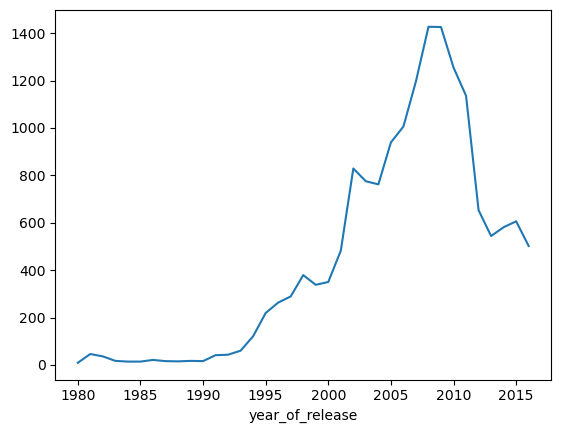

In [20]:
print(data.groupby('year_of_release')['name'].count())
data.groupby('year_of_release')['name'].count().plot()

С 1980 по 1993 выпускали десятки игр в год. Это крайне малые значения. C 1994 был двукраный рост и далее активный рост до следуещего качественного скачка в 2002. С 2002 до 2008 рост и выход на плато в время мирового кризиса в этом году. Дальше с 2012 года падение. На приведенном графике так же хорошо виден характер поведения колчесва игр в разные годы.

<Axes: xlabel='platform'>

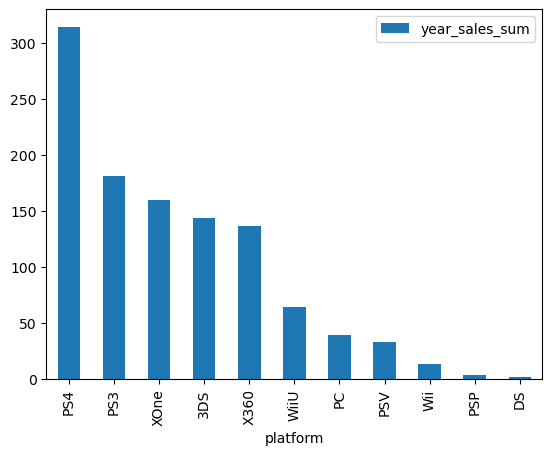

In [22]:
data.query('year_of_release >= 2013').pivot_table(index = 'platform', values = 'year_sales_sum', aggfunc = 'sum')\
.sort_values('year_sales_sum', ascending = False)\
.plot(kind = 'bar')

На разных платформах мы видим разные суммы продаж. Есть явные лидеры и утсайдеры. Продолжим работать с PS4, PS3, XOne, 3DS, X360.

In [23]:
data_pivot_year_platform_new = data.pivot_table(index = ['platform', 'year_of_release'], values = 'year_sales_sum', aggfunc = 'sum')\
.sort_values('year_sales_sum', ascending = False)\
.query('platform == ["PS4", "XOne", "3DS", "PS3", "X360"] & year_of_release >= 2013') # выделим основные платформы в отдельную переменную по сводной таблице

<Axes: xlabel='platform,year_of_release'>

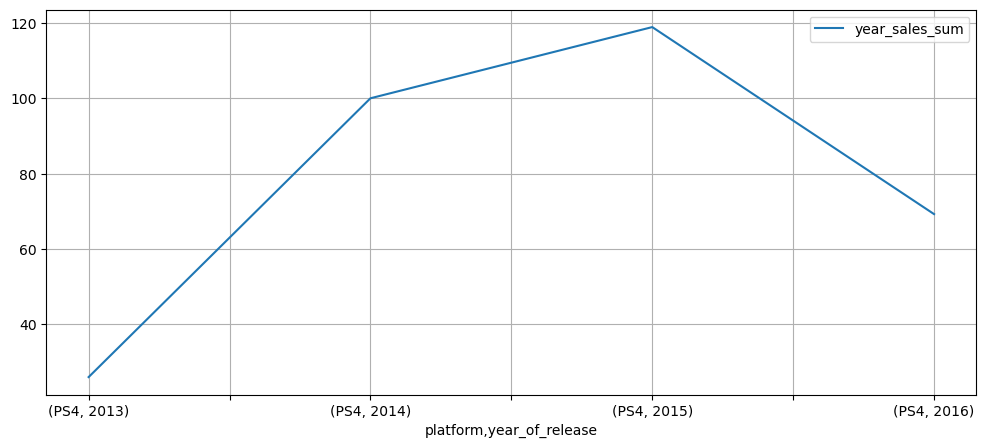

In [24]:
data_pivot_year_platform_new.query('platform =="PS4"').sort_values('year_of_release').plot(grid = True, figsize = (12,5))

<Axes: xlabel='platform,year_of_release'>

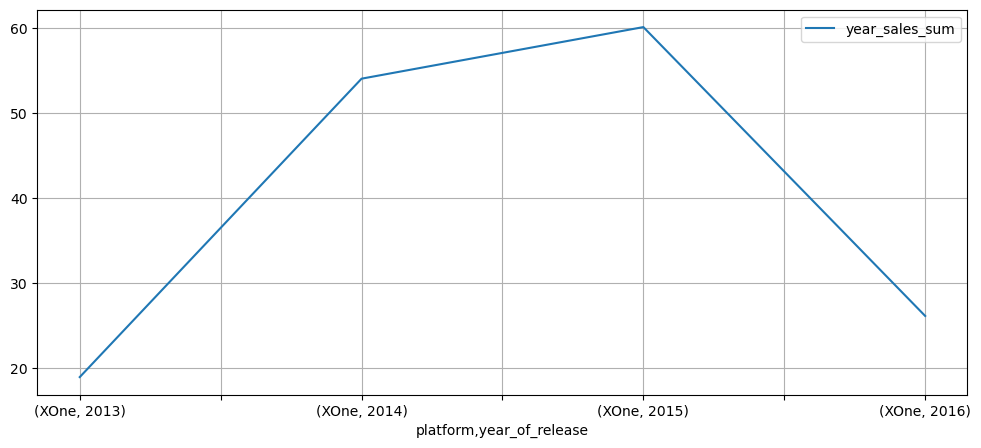

In [25]:
data_pivot_year_platform_new.query('platform =="XOne"').sort_values('year_of_release').plot(grid = True, figsize = (12,5))

<Axes: xlabel='platform,year_of_release'>

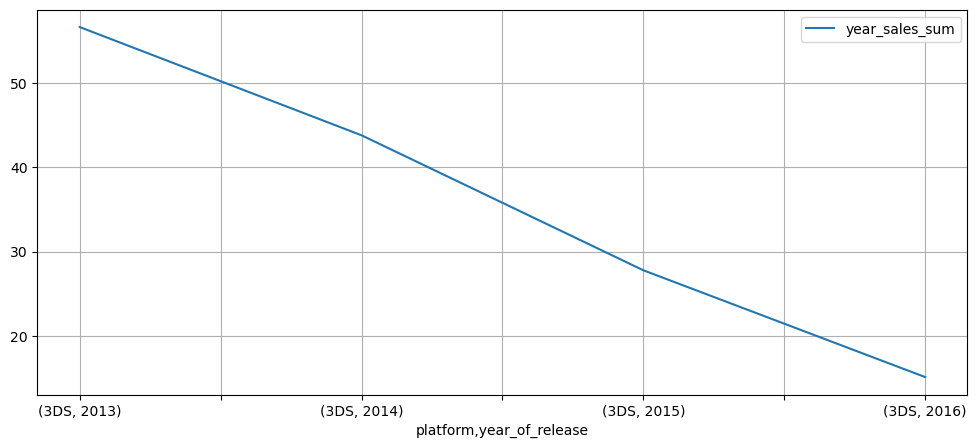

In [26]:
data_pivot_year_platform_new.query('platform =="3DS"').sort_values('year_of_release').plot(grid = True, figsize = (12,5))

<Axes: xlabel='platform,year_of_release'>

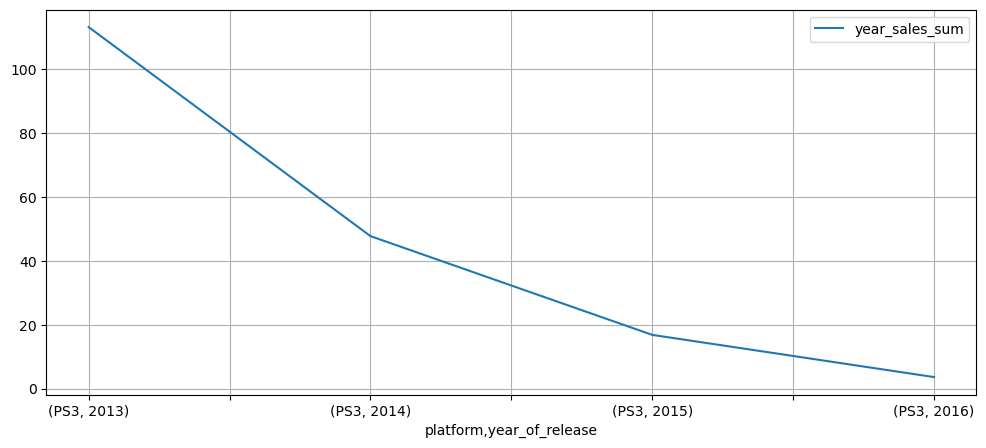

In [27]:
data_pivot_year_platform_new.query('platform =="PS3"').sort_values('year_of_release').plot(grid = True, figsize = (12,5))

<Axes: xlabel='platform,year_of_release'>

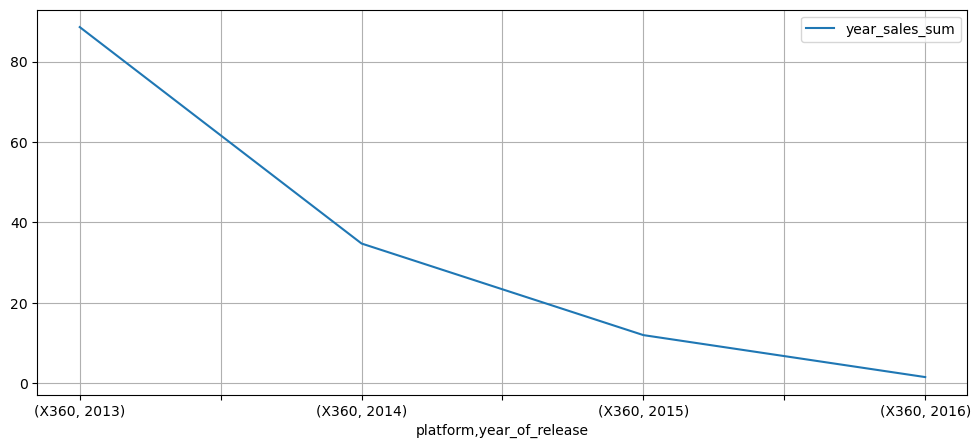

In [28]:
data_pivot_year_platform_new.query('platform =="X360"').sort_values('year_of_release').plot(grid = True, figsize = (12,5))

<Axes: title={'center': 'year_sales_sum'}, xlabel='platform'>

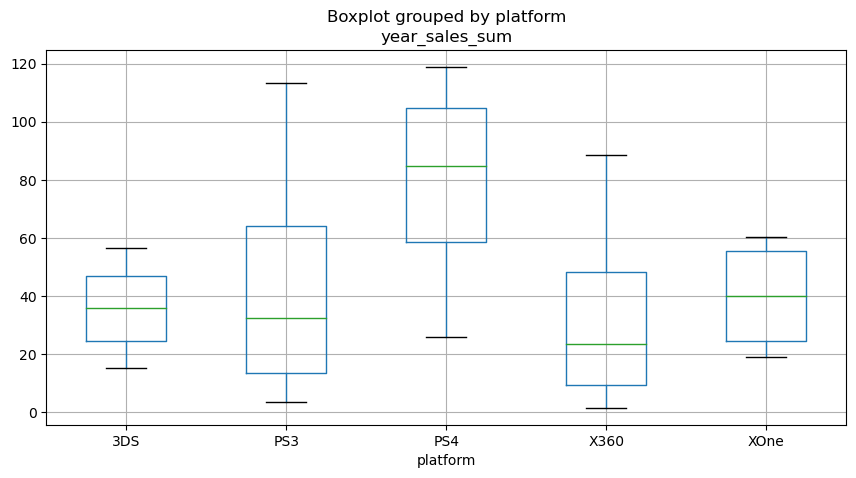

In [29]:
data_pivot_year_platform_new.boxplot(column = 'year_sales_sum', by = 'platform', figsize = (10,5))

По распределению графика с "усами" видно, что медианные значения у всех платформ разные. Самое высокое медианное значение продаж у PS4.

0.4009032235925673

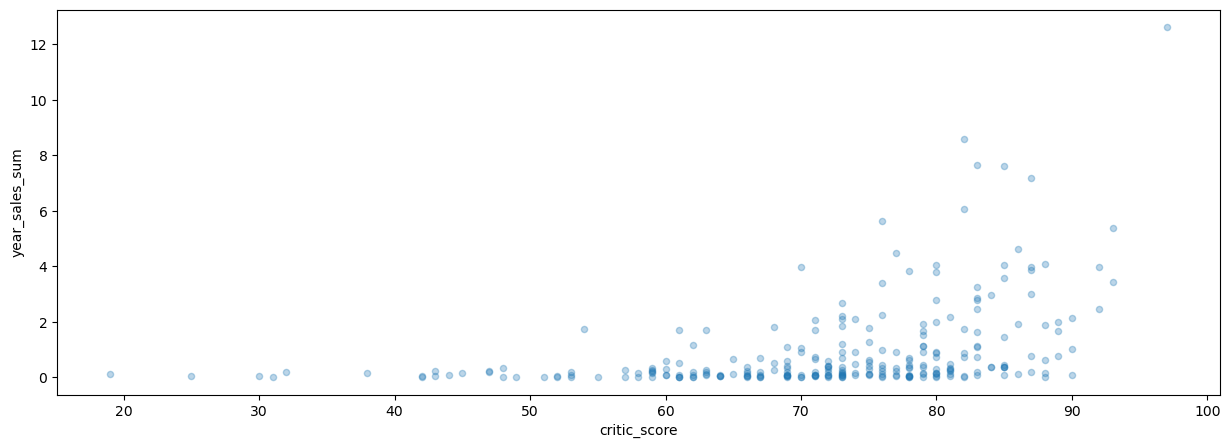

In [30]:
data.query('platform =="PS4" & year_of_release >= 2013').plot(x = 'critic_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_PS4 = data.query('platform =="PS4" & year_of_release >= 2013')
data_PS4['critic_score'].corr(data_PS4['year_sales_sum'])

Была построена диаграмма распределения внутри платформы PS4 отзывов критиков и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона так же подтверждает среднюю корреляцию между продажами и отзывами критиков.

-0.032458648363711984

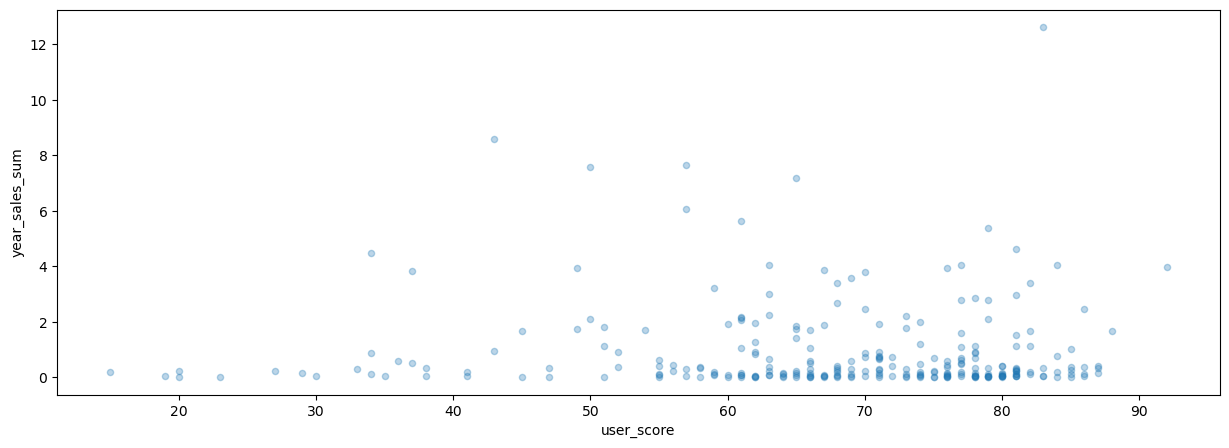

In [31]:
data.query('platform =="PS4" & year_of_release >= 2013').plot(x = 'user_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_PS4['user_score'].corr(data_PS4['year_sales_sum'])

Была построена диаграмма распределения внутри платформы PS4 отзывов пользователей и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона указывает на слабую корреляцию между продажами и отзывами пользователей.

0.21219704919848656

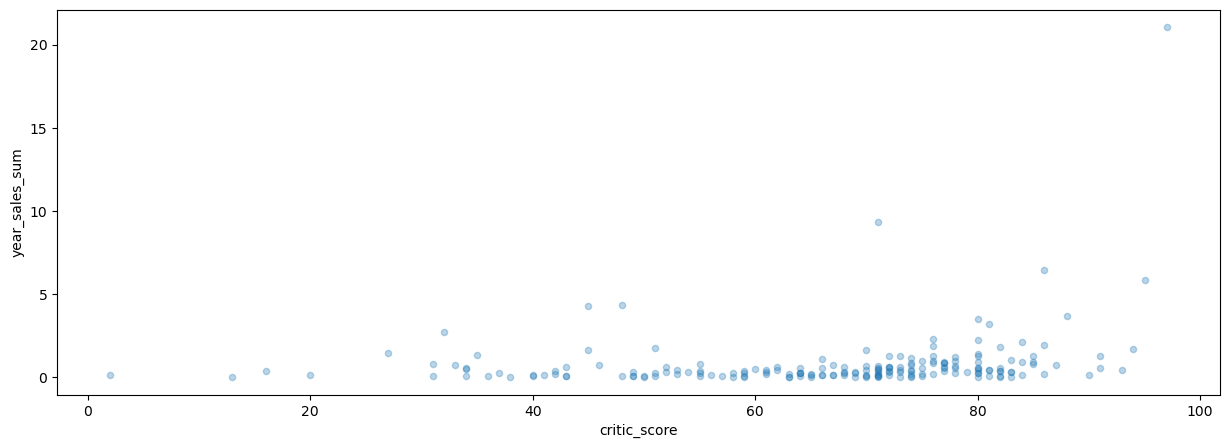

In [32]:
data.query('platform =="PS3" & year_of_release >= 2013').plot(x = 'critic_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_PS3 = data.query('platform =="PS3" & year_of_release >= 2013')
data_PS3['critic_score'].corr(data_PS3['year_sales_sum'])

Была построена диаграмма распределения внутри платформы PS3 отзывов критиков и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона так же подтверждает среднюю корреляцию между продажами и отзывами критиков.

0.005650383205421481

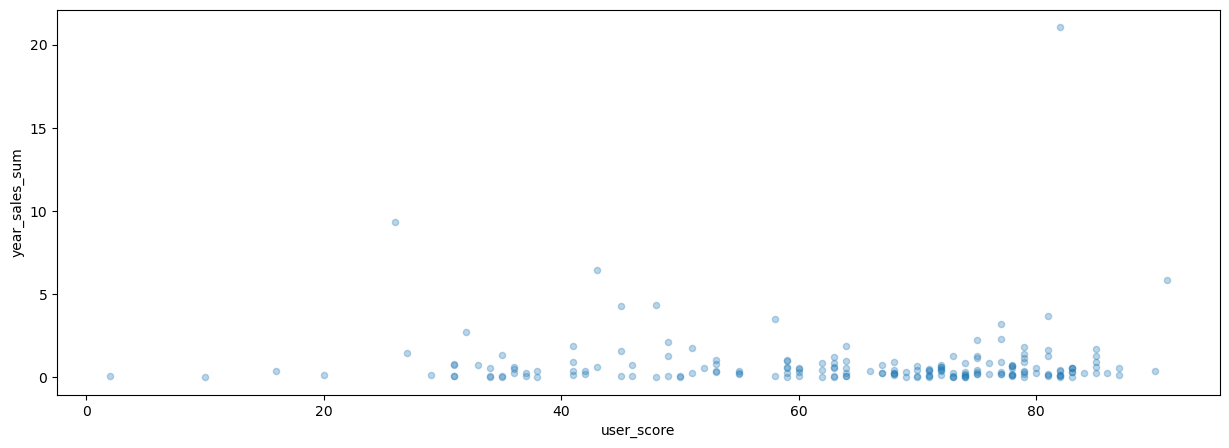

In [33]:
data.query('platform =="PS3" & year_of_release >= 2013').plot(x = 'user_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_PS3['user_score'].corr(data_PS3['year_sales_sum'])

Была построена диаграмма распределения внутри платформы PS3 отзывов пользователей и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона указывает на слабую корреляцию между продажами и отзывами пользователей.

0.4071713295687381

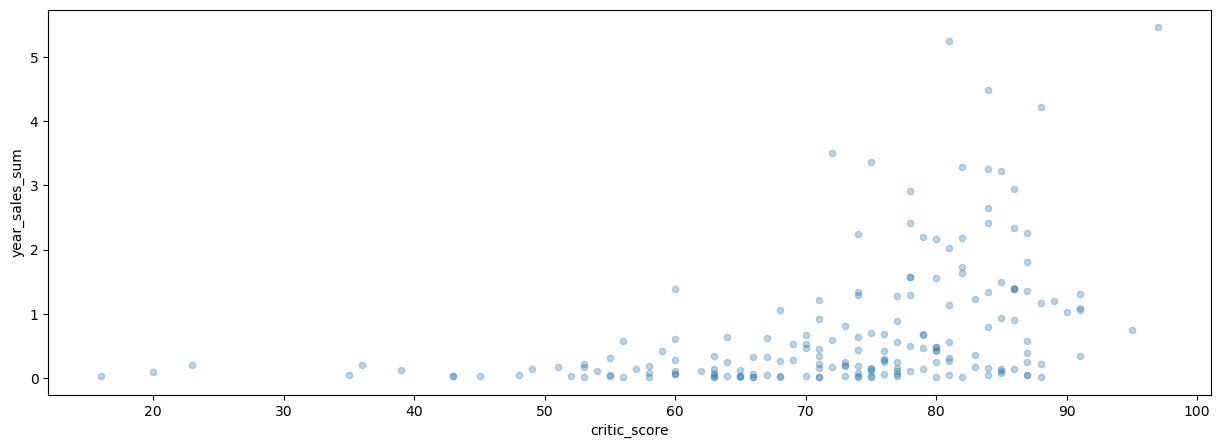

In [34]:
data.query('platform =="XOne" & year_of_release >= 2013').plot(x = 'critic_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_XOne = data.query('platform =="XOne" & year_of_release >= 2013')
data_XOne['critic_score'].corr(data_XOne['year_sales_sum'])

Была построена диаграмма распределения внутри платформы XOne отзывов критиков и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона так же подтверждает среднюю корреляцию между продажами и отзывами критиков.

-0.06383819139818173

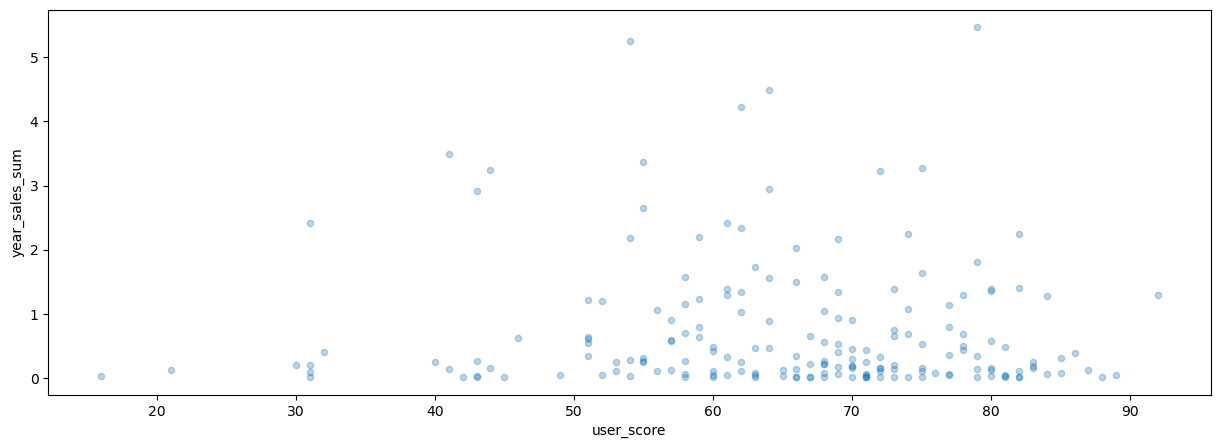

In [35]:
data.query('platform =="XOne" & year_of_release >= 2013').plot(x = 'user_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_XOne['user_score'].corr(data_XOne['year_sales_sum'])

Была построена диаграмма распределения внутри платформы XOne отзывов пользователей и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона указывает на слабую корреляцию между продажами и отзывами пользователей.

0.299438568693571

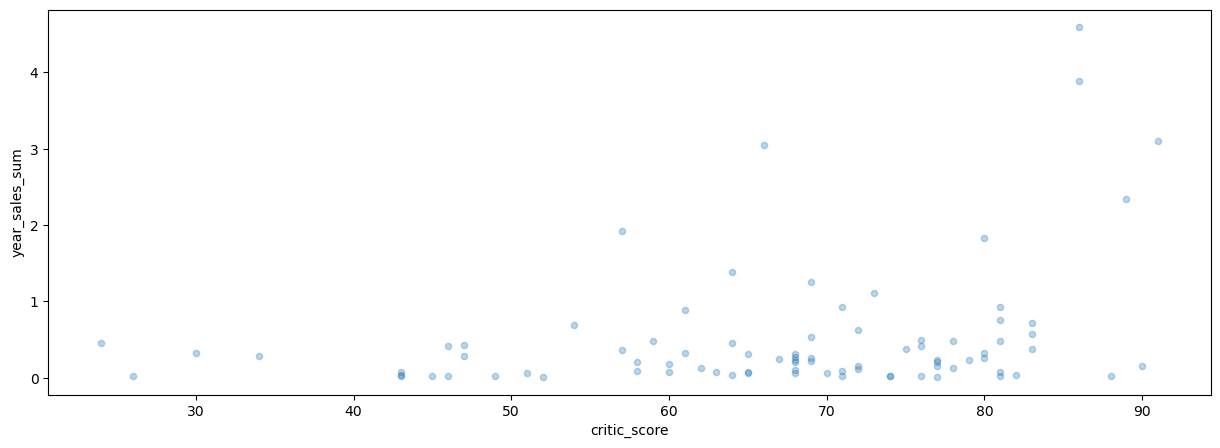

In [36]:
data.query('platform =="3DS" & year_of_release >= 2013').plot(x = 'critic_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_3DS = data.query('platform =="3DS" & year_of_release >= 2013')
data_3DS['critic_score'].corr(data_3DS['year_sales_sum'])

Была построена диаграмма распределения внутри платформы 3DS отзывов критиков и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона так же подтверждает среднюю корреляцию между продажами и отзывами критиков.

0.25889104130589985

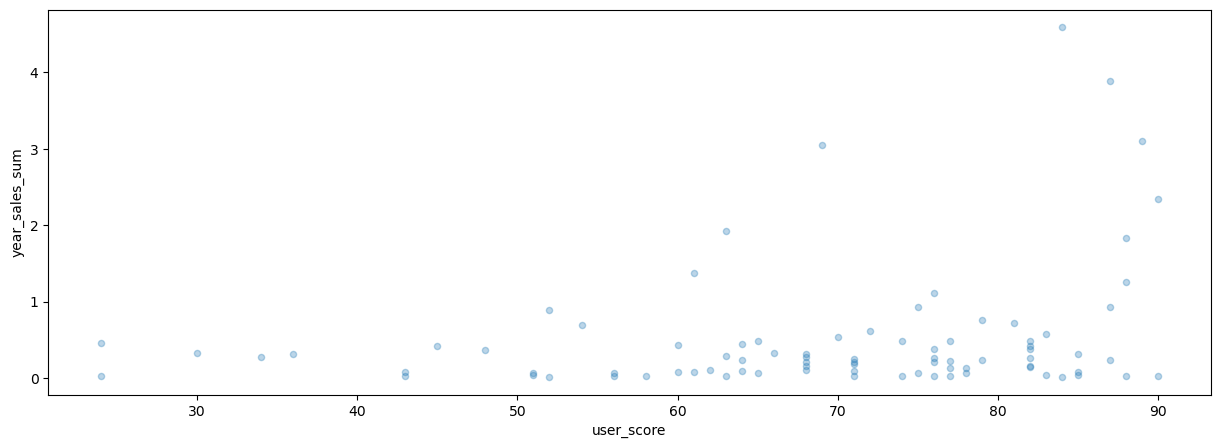

In [37]:
data.query('platform =="3DS" & year_of_release >= 2013').plot(x = 'user_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_3DS['user_score'].corr(data_3DS['year_sales_sum'])

Была построена диаграмма распределения внутри платформы 3DS отзывов пользователей и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона так же подтверждает среднюю корреляцию между продажами и отзывами критиков.

0.2415199936311558

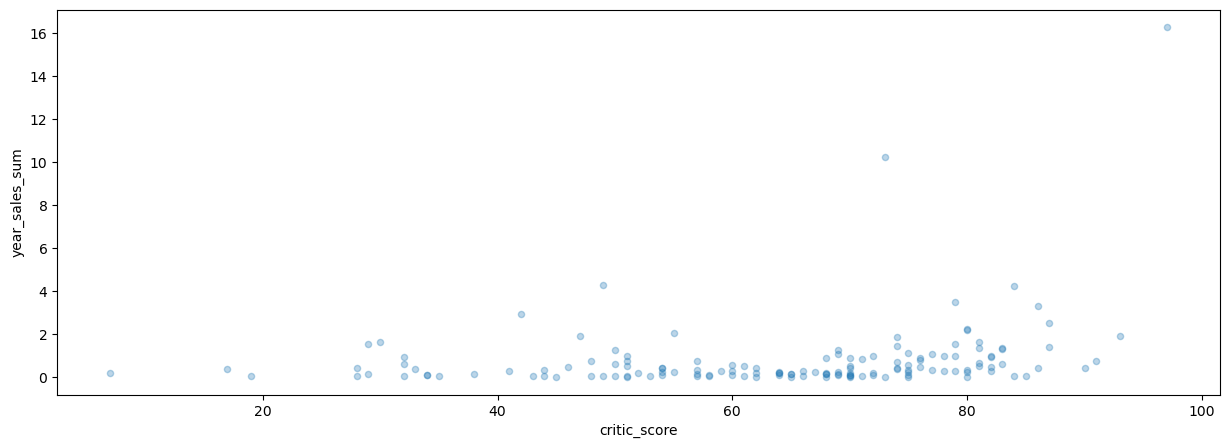

In [38]:
data.query('platform =="X360" & year_of_release >= 2013').plot(x = 'critic_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_X360 = data.query('platform =="X360" & year_of_release >= 2013')
data_X360['critic_score'].corr(data_X360['year_sales_sum'])

Была построена диаграмма распределения внутри платформы X360 отзывов критиков и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона указывает на среднюю корреляцию между продажами и отзывами критиков.

-0.011742185147181337

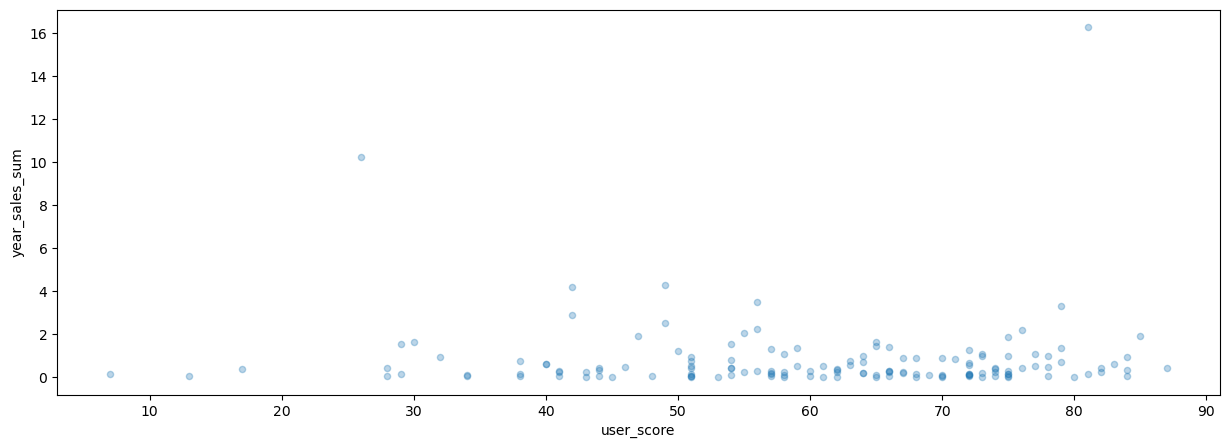

In [39]:
data.query('platform =="X360" & year_of_release >= 2013').plot(x = 'user_score', y = 'year_sales_sum', kind = 'scatter', alpha = 0.3, figsize = (15,5))
data_X360['user_score'].corr(data_X360['year_sales_sum'])

Была построена диаграмма распределения внутри платформы X360 отзывов пользователей и суммарных продаж. Характер поведения диаграммы указывает что количество проданных копий увеличивается с ростом оценок. Коэффециент корреляции Пирсона указывает на слабую корреляцию между продажами и отзывами пользователей.

Из проведенного выше анализа по корреляции отзывов и продаж копий игр в рамках платформы мы можем сделать следующие выводы:

1) Установлена корреляция между отзывами критиков и продажами и чаще она стремиться к средней корреляции

2) Установлена корреляция между отзывами пользователей и продажами и она стремится к слабой корреляции

3) Во всех случаях корреляция между отзывами критиков и продажами выше чем отзывами пользователей и продажами

<Axes: xlabel='genre'>

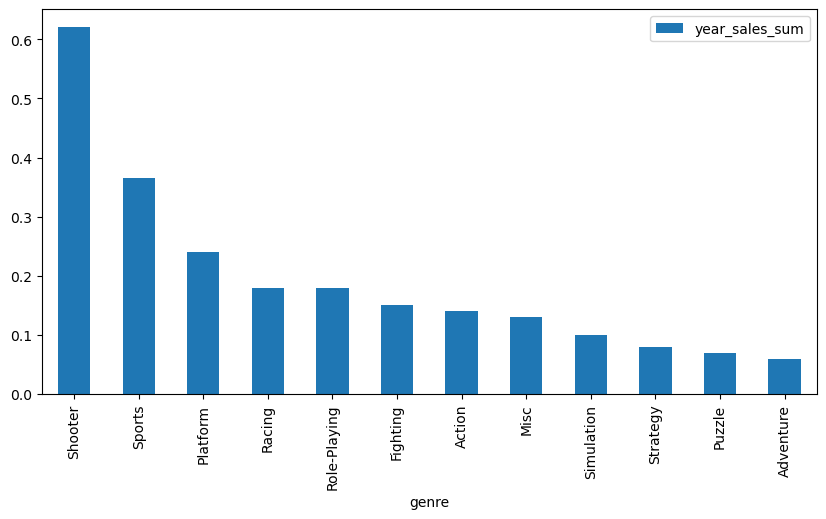

In [40]:
data_top_five_new = data.query('platform == ["PS4", "XOne", "3DS", "PS3", "X360"] & year_of_release >= 2013')
data_top_five_new.pivot_table(index = 'genre', values = 'year_sales_sum', aggfunc = 'median')\
.sort_values('year_sales_sum', ascending = False)\
.plot(kind = 'bar', figsize = (10,5))

По критерию медианного значения лучше всего себя проявляют жанры Shooter, Sports, Platform, Racing,  Role-Playing.

Хуже всех Adventure, Strategy, Puzzle.

# Составим портрет пользователя каждого региона

 Рассмотрим рынок Северной Америки

<Axes: xlabel='platform'>

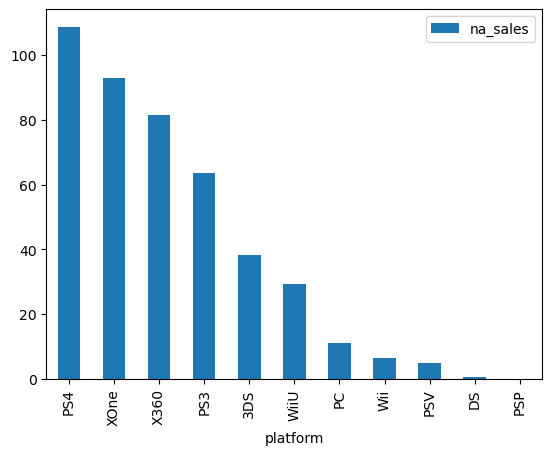

In [42]:
data_new_years_new = data.query('year_of_release >= 2013')
data_new_years_new.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')\
.sort_values('na_sales', ascending = False)\
.plot(kind = 'bar')

In [43]:
data_top_five_new['na_sales'].sum() / data.query('year_of_release >= 2013')['na_sales'].sum()

0.8800804185419571

Самые популярные топ-5 платформы в Северной Америке (СА далее) с 2013 года в порядке убывания по продажам копий игр PS4, XOne, X360, PS3, 3DS.  Они совпадают с выбранными ранее топ-5 по всему миру, поэтому использовали уже созданную ранее переменную.

<Axes: xlabel='genre'>

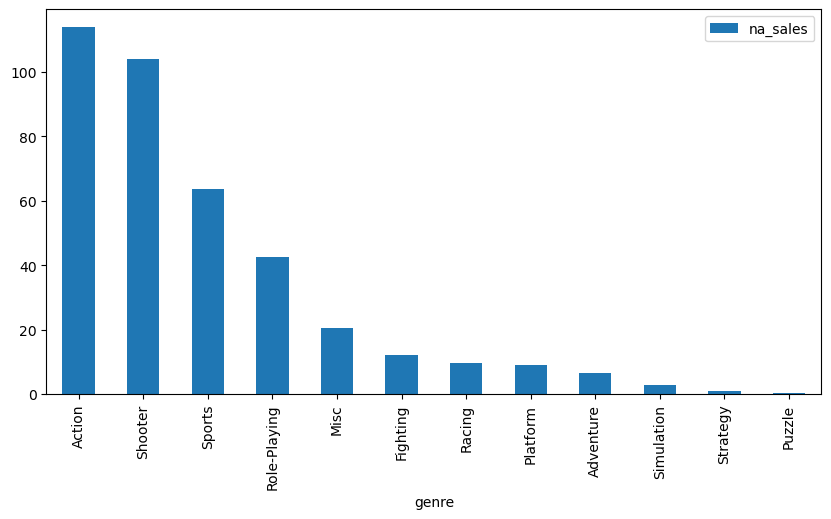

In [44]:
data_top_five_new.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')\
.sort_values('na_sales', ascending = False)\
.plot(kind = 'bar', figsize = (10,5))

Обратим внимание, что наиболее популярные жанры совпали с мировой тенденцией по СА - это Action, Shooters, Sports, Role-Playing, Misc.

Меньше всего прибыли принесли Strategy, Puzzle, Adventure.

<Axes: xlabel='rating'>

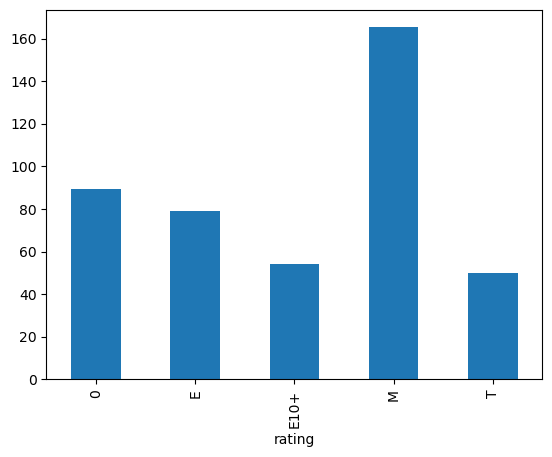

In [45]:
data_new_years_new.groupby('rating')['na_sales'].sum().plot(kind = 'bar')

По графику видно что игры с рейтингом M - содержащие насилие имею самое большое количество продаж. Хотя они по идее должны иметь меньшую публику из за возрасного ограничения. Так же это подтверждает что жанр Action имеет самые большие продажи, так как в нем частро встречается взаимодействие с другими игроками или НПС.

В каждой категории есть продажи, рейтинг ЕС - для детей младшего возраста имеет минимальные продажи и это понятно так как в основном игры делаются для более сложных взаимодействий.

Рейтиг RP это псевдорейтинг который присваивается игре на стадии разработке до ее релиза.

Нулевое значение это данные без указанной категории. 

Рассмотрим рынок Европы

<Axes: xlabel='platform'>

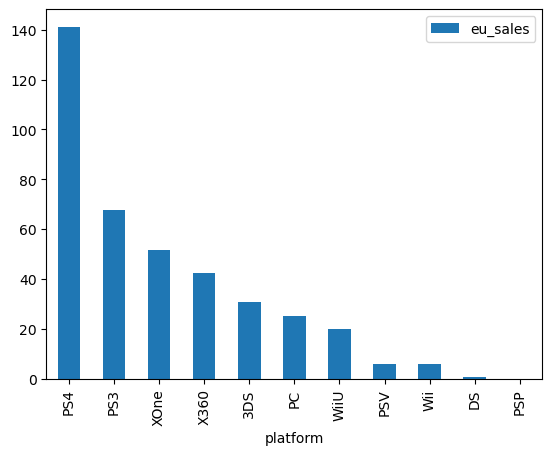

In [46]:
data_new_years_new.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')\
.sort_values('eu_sales', ascending = False)\
.plot(kind = 'bar')

In [47]:
data_new_years_new.query('platform == ["PS4", "XOne", "3DS", "PS3", "X360"]')['eu_sales'].sum() / data_new_years_new['eu_sales'].sum()

0.8514647018331082

Самые популярные топ-5 платформы в Европе с 2013 года в порядке убывания по продажам копий игр PS4, PS3, XOne, X360, 3DS

Доля продаж в этом регионе топ-5 составила 85% от продаж всех платформ с 2013 года. 

<Axes: xlabel='genre'>

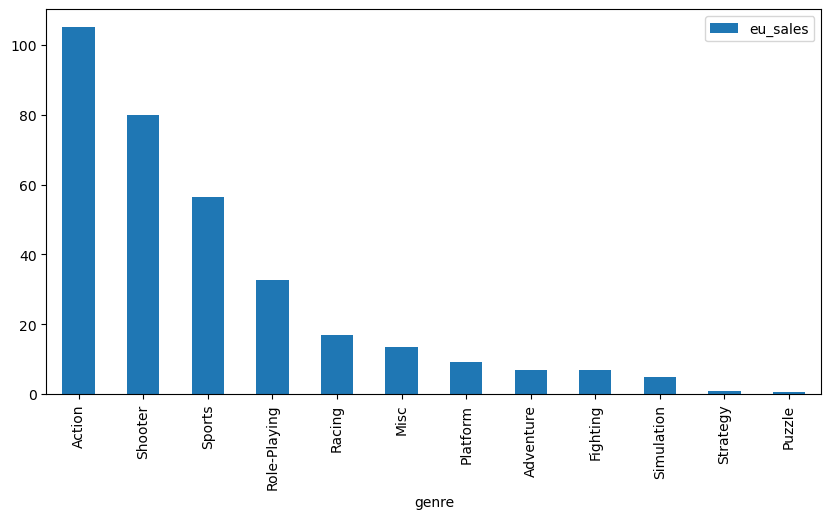

In [48]:
data_new_years_new.query('platform == ["PS4", "XOne", "3DS", "PS3", "X360"]')\
.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')\
.sort_values('eu_sales', ascending = False)\
.plot(kind = 'bar', figsize = (10,5))

Наиболее популярные жанры - это Action, Shooters, Sports,  Role-Playing, Racing.

Меньше всего прибыли принесли Strategy, Puzzle, Simulations.

<Axes: xlabel='rating'>

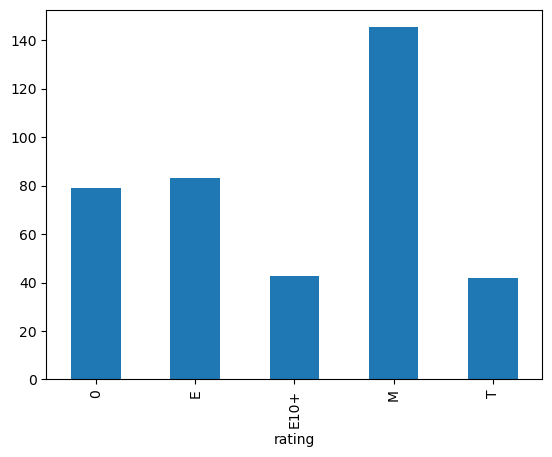

In [49]:
data_new_years_new.groupby('rating')['eu_sales'].sum().plot(kind = 'bar')

Распределение по Европе выглядит практически так же как в СА, что подтверждает наши утверждения, что несмотря на возрастные ограничения игры с рейтингом жестокости имеют самые высокие продажи. 

Распределение совпадает с СА и это не удивительно так как популярные жанры так же практически полностью совпадают.

Рассмотрим рынок Японии

<Axes: xlabel='platform'>

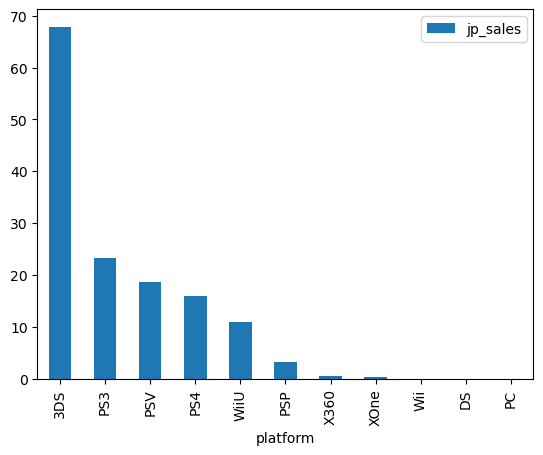

In [50]:
data_new_years_new.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')\
.sort_values('jp_sales', ascending = False)\
.plot(kind = 'bar')

In [51]:
data_new_years_new.query('platform == ["PS4", "WiiU", "3DS", "PS3", "PSV"]')['jp_sales'].sum() / data_new_years_new['jp_sales'].sum()

0.9702372496093196

Самые популярные топ-5 платформы в Японии с 2013 года в порядке убывания по продажам копий игр  3DS, PS3, PSV, PS4, WiiU, что достаточно сильно отличается от Европы и СА.

Доля продаж в этом регионе топ-5 составила 97% от продаж всех платформ с 2013 года.

<Axes: xlabel='genre'>

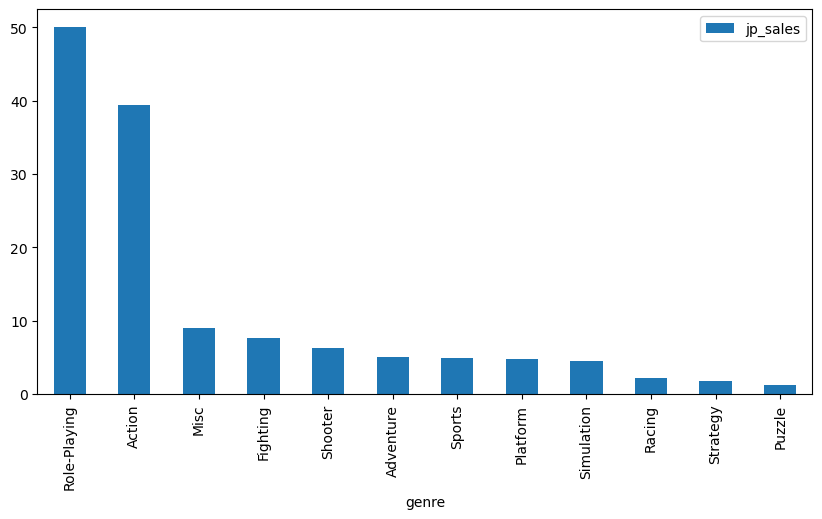

In [52]:
data_new_years_new.query('platform == ["PS4", "WiiU", "3DS", "PS3", "PSV"]')\
.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')\
.sort_values('jp_sales', ascending = False)\
.plot(kind = 'bar', figsize = (10,5))

Наиболее популярные жанры - это Role-Playing, Action, Misc, Fighting, Shooter.

Меньше всего прибыли принесли Strategy, Rasing, Racing.

По данному рынку мы наблюдаем совершенно другие приоритеты в жанрах. Позиции Сохранил только жанр Action.

<Axes: xlabel='rating'>

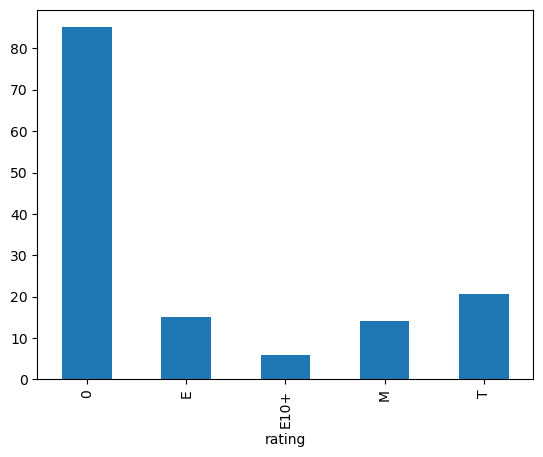

In [53]:
data_new_years_new.groupby('rating')['jp_sales'].sum().plot(kind = 'bar')

В Японии система рейтингов США судя по всему не применяется так как основное количество продаж скопилось в рейтинге нуля то есть с пропущенным значением. Однако остальные рейтинги имеют практически полное совпадение по соотношению с рейтингами остальных регионов.

За исключением рейтинга М с самой большой жестокостью, в Японии этот рейтинг имеет меньшие показатели чем в других регионах по отношению к другим рейтингам. 

Промежуточный вывод по трем рынкам:

1) Экономически СА очень похож мировые рейтинги по более всего востребованным платформам так как они совпадают.

2) По наиболее популярные жанры СА и мира так же совпадают.

3) В каждом из трех рынков доля продаж топ 5 платформ составляет в стреднем 85% от общих продаж по региону.

4) Продажи по возрастным рейтингам совпадают с продажами по жанрам.

5) Следует сделать вывод что СА и Европа как рынки очень схожи, в то время как в рынке Японии другие интересы.

# Проверим гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC с 2013 года одинаковые;

H_0: Рейтинг (user_score) пользователей платформы (platform) Xbox One = рейтинг (user_score) пользователей платформы (platform) PC

H_a: Рейтинг (user_score) пользователей платформы (platform) Xbox One ≠ рейтинг (user_score) пользователей платформы (platform) PC

alpha = 0.05

In [54]:
results = st.ttest_ind(data_new_years_new[data_new_years_new['platform'] =='X360']['user_score'], \
                       data_new_years_new[data_new_years_new['platform'] =='PC']['user_score'], equal_var = False, nan_policy = 'omit')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14948331623399314
Не получилось отвергнуть нулевую гипотезу


Вывод: средние пользовательские рейтинги платформ Xbox One и PC с 2013 года одинаковые.

Для проверки первой нулевой гипотизы был использован метод ttest_ind так как с помощью него сравнивают независимые данные

Средние пользовательские рейтинги жанров Action и Sports с 2013 года разные.

H_0: Рейтинг (user_score) пользователей жанра (genre) Action = рейтинг (genre) пользователей жанра (Sports) Sports

H_a: Рейтинг (user_score) пользователей жанра (genre) Action ≠ рейтинг (genre) пользователей жанра (Sports) Sports

alpha = 0.05

In [55]:
results = st.ttest_ind(data_new_years_new[data_new_years_new['genre'] =='Action']['user_score'], \
                       data_new_years_new[data_new_years_new['genre'] =='Sports']['user_score'], equal_var = False, nan_policy = 'omit')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.894469247577245e-21
Отвергаем нулевую гипотезу


В данном случае было проще построить гипотизу от обратного, так как с точки зрения порядка и логики легче правильнее всего будет проверять равеноство.

Вывод: средние пользовательские рейтинги жанров Action и Sports с 2013 года действительно разные.

# Общий вывод

Нам предоставлены данные из интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры.

Стояла задача выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. В ходе анализа для актуальности информации мы условились использовать данные с 2013 года.

1) Была проведене предобработка данных. Изменили названия столбцов, разобрались со странными значениям, заменили пустые значения там где это нужно, удалили некоторые строки с обоснованием, преобразовали данные в нужные типы, посчитали суммарные продажи во всех регионах и записали их в отдельный столбец.

2) Провели исследовательский анализ данных:

С 1980 по 1993 выпускали десятки игр в год. C 1994 был двукраный рост и далее активный рост до следуещего качественного скачка в 2002. С 2002 до 2008 рост и выход на плато в время мирового кризиса в этом году. Дальше с 2012 года падение. Приняли решение рассматривать период с 2006 по 2016 год так как с одной стаороны это достаточно свежий массив, с другой хватает данных, с третьей он звахватывает все характерные поведения рынка как рост, падение и плато, что видно по графику.
На разных платформах мы видим разные суммы продаж. Есть явные лидеры и утсайдеры.
Из графиков мы видим нисходящую тенденцию по продажам копий игр на платформах. Это может быть связано как с появлением мобильных игр, так и со сменой способа монетизации. Если раньше разработчики зарабатывали на продажах копий, то сейчас основаная монетизация происходит из внутреигровых покупок. Топ 5 выделаем платформы 3DS, XOne, PS3, X360, PS4.
Медианные значения у всех платформ разные. Самое высокое медианное значение продаж у PS4.
Из проведенного выше анализа по корелляции отзывов и продаж копий игр в рамках платформы мы можем сделать следующие выводы: а) Установлена корреляция между отзывами критиков и продажами и чаще она стремиться к средней корреляции. б) Установлена корреляция между отзывами пользователей и продажами и она стремится к слабой корреляции. в) Во всех случаях корреляция между отзывами критиков и продажами выше чем отзывами пользователей и продажами.
По критерию медианного значения лучше всего себя проявляют жанры Shooter, Sports, Platform, Racing, Role-Playing.
Хуже всех Adventure, Strategy, Puzzle.
3) Составили портрет пользователя каждого региона:

Самые популярные топ-5 платформы в Северной Америке (СА далее) с 2013 года в порядке убывания по продажам копий игр PS4, XOne, X360, PS3, 3DS. Они совпадают с выбранными ранее топ-5 по всему миру.

Обратим внимание, что наиболее популярные жанры совпали с мировой тенденцией по СА - это Action, Shooters, Sports, Role-Playing, Misc.

Количество продаж по возрастному ограничению совпадает с жанрами, т.е. игры с самыми большими ограничениями сохраняют пользовательский спрос.

Самые популярные топ-5 платформы в Европе с 2013 года в порядке убывания по продажам копий игр PS4, PS3, XOne, X360, 3DS

Наиболее популярные жанры - это Action, Shooters, Sports, Role-Playing, Racing.

Распределение по Европе выглядит практически так же как в СА, что подтверждает наши утверждения, что несмотря на возрастные ограничения игры с рейтингом жестокости имеют самые высокие продажи.

Самые популярные топ-5 платформы в Японии с 2013 года в порядке убывания по продажам копий игр 3DS, PS3, PSV, PS4, WiiU, что достаточно сильно отличается от Европы и СА.

Наиболее популярные жанры - это Role-Playing, Action, Misc, Fighting, Shooter.

В Японии система рейтингов США судя по всему не применяется так как основное количество продаж скопилось в рейтинге нуля то есть с пропущенным значением. Однако остальные рейтинги имеют практически полное совпадение по соотношению с рейтингами остальных регионов.

Как итог вывод по всем рынкам:

Экономически СА очень похож мировые рейтинги по более всего востребованным платформам так как они совпадают.

По наиболее популярные жанры СА и мира так же совпадают.

В каждом из трех рынков доля продаж топ 5 платформ составляет в стреднем 80% от общих продаж по региону.

Продажи по возрастным рейтингам совпадают с продажами по жанрам.

Следует сделать вывод что СА и Европа как рынки очень схожи, в то время как в рынке Японии другие интересы.

4) Проверили гипотезы:

С помощью т-теста по сравнению средних независимых величин было установлено, что средние пользовательские рейтинги платформ Xbox One и PC с 2013 года одинаковые.

Средние пользовательские рейтинги жанров Action и Sports с 2013 года различны.